# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
os.chdir('../')

import datetime
from pathlib import Path

import numpy as np

import torch

from collections import deque

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from p2_continuous_control.agents.agent_td3 import AgentTD3

In [2]:
SEED = 42
SCORE_TARGET = 30.0
SCORE_WINDOW = 100

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create folder architecture
PROJECT = 'p2_continuous_control'
START_TIME = datetime.datetime.now().strftime('%m-%d-%Y_%Hh%Mm')
EXPERIMENT_FOLDER = f'{PROJECT}/experiments/{START_TIME}'
Path(EXPERIMENT_FOLDER).mkdir(parents=True, exist_ok=False)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env_path = f'{PROJECT}/Reacher_Linux/Reacher.x86_64'
env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Algorithm

The first option for the environment was DDPG (Deep Deterministic Policy Gradient), an algorithm that has shown a SOTA performance in many environments. DDPG consists in an improved version of DQN, based on the Actor-Critic architecture: the actor learns the policy (mapping of states to actions), while the critic learns the action value function (mapping of states and actions, provided by the actor, to values).

However, many drawbacks have been shown by the community and, therefore, a better option should be to use TD3 (Twin Delayed DDPG), an improved DDPG which addresses some of the issues of this algorithm, such as its overestimation of Q-values that leads to the exploitation of bad actions from the policy. To solve DDPG's issues, TD3 uses three different tricks:

- **Twin critic networks**: TD3 learns two different value functions/critics, with their corresponding local and target networks, and uses the smaller of the two values as target in the Bellman equation updates. With this trick, the overestimation of bad actions, especially in early stages of the training, is assessed and a more stable performance is achieved.

- **Delayed policy updates**: TD3 updates the policy (both local and target networks) less frequently than the value function, thus also dumpening this overestimation of bad actions before updating the critic, and so, contributing to a more stable training.

- **Noise regularization**: due to the tendency of deterministic policies to overfit to spikes in values estimates, the addition of noise helps to stabilise training, by reducing the variances of target values.

Further improvements are achieved borrowing techniques from other algorithms, such as the replay buffer from DQN and the soft-updates and noise process from DDPG.

In addition to this, several hyperparameters have been chosen for training the agent:

**Networks parameters**:

- actor_fc1_units = 400 # first hidden layer
- actor_fc2_units = 300 # second hidden layer
- critic_fc1_units = 400 # first hidden laye
- critic_fc2_units = 300 # second hidden layer

**Hyperparameters**:
- batch_size = 128        # minibatch size
- buffer_size = int(1e6)  # replay buffer size
- learn_every = 20        # how often to update the actor
- learn_iterations = 20   # number of update iterations
- gamma = 0.995           # discount factor
- tau = 0.001             # for soft update of target parameters
- actor_lr = 1e-4         # actor learning rate
- critic_lr = 1e-3        # critic learning rate

In [6]:
# define the agent
agent = AgentTD3(
    state_size=state_size,
    action_size=action_size,
    hyperparams=dict(),
    device=DEVICE,
    seed=SEED
)

### 4. Training

In [7]:
# training hyperparameters
n_episodes = 250   # maximum number of training episodes
max_t = 1000       # maximum number of timesteps per episode

scores = []                                 # scores for each episode
scores_window = deque(maxlen=SCORE_WINDOW)  # last 100 scores
scores_window_means = []                    # average max scores for each episode

# training loop
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    states = env_info.vector_observations              # get the current stat
    agent.reset()                                      # initialize agents
    score = np.zeros(num_agents)                       # initialize scores

    for t in range(max_t):
        actions = agent.select_action(states)       # get the action from the agent
        env_info = env.step(actions)[brain_name]    # send the action to the environment
        next_states = env_info.vector_observations  # get the next state
        rewards = env_info.rewards                  # get the reward
        dones = env_info.local_done                 # see if episode has finished

        # save experience tuple (of each agent) into replay buffer
        for i_agent in range(0, num_agents):
            experience = (
                states[i_agent],
                actions[i_agent],
                rewards[i_agent],
                next_states[i_agent],
                dones[i_agent]
            )
            agent.memory.add(data=experience)

        states = next_states  # roll over states to next time step
        score += rewards      # update the scores

        # Train each agent
        agent.learn_batch(timestep=t)

        if np.any(dones):
            break

    # Score is updated for each agent, therefore use mean as an estimate
    score = np.mean(score)

    scores.append(score)
    scores_window.append(score)

    window_score_mean = np.mean(scores_window)  # save mean of window scores
    scores_window_means.append(window_score_mean)

    print(
        '\rEpisode {}\tEpisode total score: {:.2f}\tWindow Score: {:.2f}'
        .format(i_episode, score, window_score_mean),
        end=""
    )

    if i_episode % 100 == 0:
        print(
            '\rEpisode {}\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

    if window_score_mean >= SCORE_TARGET:
        print(
            '\nEnvironment solved in {:d} episodes!\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

        print(f'Saving weights into {EXPERIMENT_FOLDER} folder...')
        torch.save(
            agent.actor_local.state_dict(),
            f'{EXPERIMENT_FOLDER}/weights_actor_episode_{i_episode}.pth'
        )
        torch.save(
            agent.critic_local.state_dict(),
            f'{EXPERIMENT_FOLDER}/weights_critic_episode_{i_episode}.pth'
        )

        break

Episode 100	Window Score: 16.40: 28.07	Window Score: 16.40
Episode 167	Episode total score: 35.07	Window Score: 30.08
Environment solved in 167 episodes!	Window Score: 30.08
Saving weights into p2_continuous_control/experiments/04-26-2020_19h45m folder...


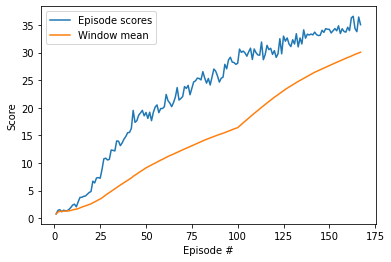

Saving figure into p2_continuous_control/experiments/04-26-2020_19h45m folder...


In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label='Episode scores')
plt.plot(np.arange(1, len(scores) + 1), scores_window_means, label='Window mean')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# save figure to file
print(f'Saving figure into {EXPERIMENT_FOLDER} folder...')
fig.savefig(f'{EXPERIMENT_FOLDER}/scores.png')

In [9]:
# close the environment
env.close()

### 5. Future work

#### 5.1. Further improvements

I could not tune neither the delayed update nor the noise addition, and I think that this should be a must since I've seen other implementations outperforming mine by far. The problem of this is the huge amount of possibilities and, thus, a directed search must be performed, borrowing insights from other works and implementations.

In addition, I performed no architecture search, which I think could help me to fine-tune the performance for each environment.

#### 5.2. Other algorithms

Other algorithms that I think could be interesting to benchmark with TD3 are PPO and TRPO.

### 6. References

**TD3 paper**: https://arxiv.org/abs/1802.09477

**TD3 explanations**:
- https://spinningup.openai.com/en/latest/algorithms/td3.html
- https://towardsdatascience.com/td3-learning-to-run-with-ai-40dfc512f93
- https://towardsdatascience.com/reinforcement-learning-ddpg-and-td3-for-news-recommendation-d3cddec26011

**TD3 implementations**:
- https://github.com/djbyrne/TD3
- https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch
- https://github.com/wiflore/DRL_Continuous_Control-TD3_Pytorch